In [68]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [69]:
paths = glob.glob('../results_hyper/*.txt')

In [70]:
path = paths[0]

In [71]:
def extract_row(path):
    with open(path) as fp:
        lines = fp.readlines()

        sel = list(filter(lambda line: line.startswith('{"startupTime":'), lines))
        row = json.loads(sel[0])

        _, mode, _, run = os.path.basename(path).split('-')
        run = int(run.replace('.txt', ''))
        row['mode'] = mode
        row['run'] = run
        row['path'] = path

        sel = list(filter(lambda line: 'LAMBDA compute took' in line, lines))[0]
        cost = float(sel[sel.find('cost $')+6:].strip())

        row['cost'] = cost

        return row

In [72]:
rows = []
for path in paths:
    rows.append(extract_row(path))
    
df = pd.DataFrame(rows)

In [73]:
df.groupby('mode').agg(['mean', 'std']).reset_index()

mode startupTime              jobTime            run            cost  \
                  mean       std       mean       std mean      std   mean   
0    hyper    0.259198  0.032356  48.507514  1.493548  5.5  3.02765  0.591   
1  nohyper    0.285138  0.050326  68.055696  4.436225  5.5  3.02765  0.967   

             
        std  
0  0.003162  
1  0.060009

In [74]:
def extract_path_stats_row(path):
    with open(path) as fp:
        lines = fp.readlines()
        needle = 'LAMBDA paths rows took:'
        sel = list(filter(lambda line: needle in line, lines))[0]

        sel = sel[sel.find('normal:'):]

        _, normal, _, general, _, interpreter, _, unresolved = sel.strip().split(' ')


        row = {'normal' : int(normal),
               'general': int(general),
               'interpreter' : int(interpreter),
               'unresolved' : int(unresolved)}

        _, mode, _, run = os.path.basename(path).split('-')
        row['mode'] = mode
    return row

In [75]:
df_rows = pd.DataFrame([extract_path_stats_row('../results_hyper/flights-hyper-run-1.txt'),
                       extract_path_stats_row('../results_hyper/flights-nohyper-run-1.txt')])

In [76]:
df_rows.style.format(thousands=",")
print(df_rows[['mode', 'normal', 'general', 'interpreter', 'unresolved']].to_latex(index=None))

\begin{tabular}{lrrrr}
\toprule
    mode &     normal &    general &  interpreter &  unresolved \\
\midrule
   hyper &  149930703 &   44830574 &      7687788 &      238590 \\
 nohyper &     448620 &  179364496 &     22635949 &      238590 \\
\bottomrule
\end{tabular}



In [77]:
!open ../results_hyper

In [78]:
data['stageStartTimestamp']

1655210863483049074

In [164]:
gdf = df.groupby('mode').agg(['mean', 'std']).reset_index()
gdf

mode startupTime              jobTime            run            cost  \
                  mean       std       mean       std mean      std   mean   
0    hyper    0.259198  0.032356  48.507514  1.493548  5.5  3.02765  0.591   
1  nohyper    0.285138  0.050326  68.055696  4.436225  5.5  3.02765  0.967   

             
        std  
0  0.003162  
1  0.060009

In [173]:
hyper_mu, hyper_sigma, hyper_cost = gdf[('jobTime', 'mean')].iloc[0], gdf[('jobTime', 'std')].iloc[0], gdf[('cost', 'mean')].iloc[0], 
general_mu, general_sigma, general_cost = gdf[('jobTime', 'mean')].iloc[1], gdf[('jobTime', 'std')].iloc[1], gdf[('cost', 'mean')].iloc[1], 

In [168]:
hyper_mu, general_mu

(48.50751438140869, 68.05569639205933)

## paper figure

In [79]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.path import *

In [105]:
# adjust settings for final paper (colors & Co)
def adjust_settings():
    # make nice looking plot

    sns.set_style('whitegrid')
    sns.set_context('poster')  # Everything is larger

    # matplotlib.rcParams['font.family'] = "serif"

    # red 900c3f

    # 48A70B
    sns.set_palette(
        [[.22, .52, .71], [.53, .80, .81], [144 / 255., 12 / 255, 63 / 255.], [67 / 255., 135 / 255., 107 / 255.],
         [248 / 255., 194 / 255., 145 / 255.]])

    matplotlib.rc('font', family='serif', size=9)
    matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
    matplotlib.rc('text', usetex=True)
    matplotlib.rc('legend', fontsize=8)
    matplotlib.rc('figure', figsize=(2.5, 1.4))
    matplotlib.rc('axes', linewidth=0.5)
    matplotlib.rc('lines', linewidth=0.5)

In [106]:
adjust_settings()

/var/folders/6_/x53bdscx4692x09njn0kq4v00000gn/T/ipykernel_29656/2433301248.py:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])


In [124]:
def load_job(path):
    with open(path) as fp:
        data = fp.read()
        #data= data.replace('}{"container":', '},{"container":')
        data = data.replace('],[', '],"input_uris":[')
        data = json.loads(data)
        return data

In [125]:
path_hyper = '../results_hyper/flights-hyper-run-1.json'
path_nohyper = '../results_hyper/flights-nohyper-run-1.json'

data_hyper = load_job(path_hyper)
data_general = load_job(path_nohyper)

In [108]:
ts_start, ts_end = pd.to_datetime(data['stageStartTimestamp']), pd.to_datetime(data['stageEndTimestamp'])

In [127]:
sort_key = 'tsRequestEnd'

requests_hyper = data_hyper['requests']
requests_hyper = sorted(requests_hyper, key=lambda x: x[sort_key])

requests_general = data_general['requests']
requests_general = sorted(requests_general, key=lambda x: x[sort_key])

In [128]:
# fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)[source]
def requests_to_pyplot(requests, ts_start):
    x, y1, y2 = [], [], []
    x = np.arange(len(requests))
    y1, y2 = np.zeros(x.shape), np.zeros(x.shape)
    
    for i, req in enumerate(requests):
        start, end = pd.to_datetime(req['tsRequestStart']), pd.to_datetime(req['tsRequestEnd'])
        y1[i] = (end - ts_start).total_seconds()
        y2[i] = (start - ts_start).total_seconds()
    return x, y1, y2

In [134]:
n_col = np.array([53, 66, 89]) / 255.0#sns.color_palette()[0]
g_col = np.array([140, 192, 222]) / 255.0 #sns.color_palette()[1]

In [ ]:
plt.figure(figsize=(12, 6))

ts_start = pd.to_datetime(data_hyper['stageStartTimestamp'])
x, y1, y2 = requests_to_pyplot(requests_hyper, ts_start)
# pct
x = x / (len(x) -1) * 100.0
label = 'hyper \\;\\, ($\\mu={:.1f}\\mathrm{{s}}$, \\, $\\sigma={:.1f}\\mathrm{{s}}$, \\, $\\${:.2f}$)'.format(hyper_mu, hyper_sigma, hyper_cost)
plt.fill_between(x, y1, y2, alpha=.6, label=label, color=n_col, linewidth=2)

ts_start = pd.to_datetime(data_general['stageStartTimestamp'])
x, y1, y2 = requests_to_pyplot(requests_general, ts_start)
# pct
x = x / (len(x) -1) * 100
label = 'general ($\\mu={:.1f}\\mathrm{{s}}$, \\, $\\sigma={:.1f}\\mathrm{{s}}$, \\, $\\${:.2f}$)'.format(general_mu, general_sigma, general_cost)
plt.fill_between(x, y1, y2, alpha=.3, label=label, color=g_col, linewidth=2)
plt.plot(x, y2, color=g_col, linewidth=3)

plt.grid(axis='x')
plt.legend(loc='upper left', fontsize=24)
plt.ylabel('time in s')
plt.xlabel('\% of requests completed')
plt.ylim(0, 75)
plt.xlim(0, 100)

sns.despine()
plt.savefig('workshop_requests.pdf', transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)

(0.0, 100.0)

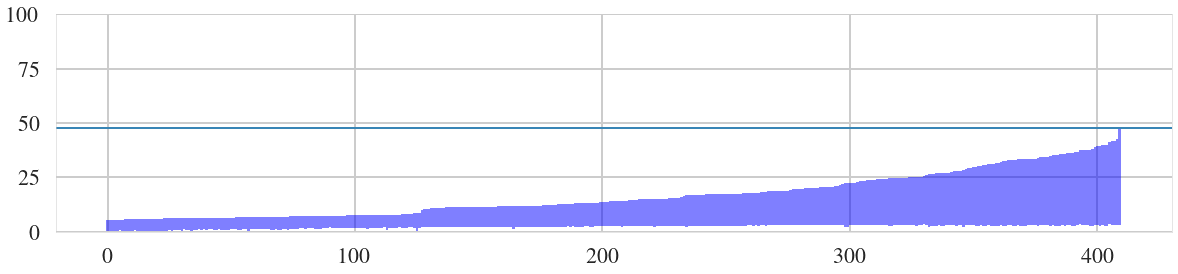

In [118]:
# plt.axhline(ts_start)
# plt.axhline(ts_end)

plt.figure(figsize=(20, 4))
job_duration = (ts_end - ts_start).total_seconds()
plt.axhline(job_duration, linewidth=2, color=)

# plot individual requests now
for i, req in enumerate(requests):
    #start, end = pd.to_datetime(task['container']['startTimestamp']), pd.to_datetime(task['container']['deadlineTimestamp'])
    start, end = pd.to_datetime(req['tsRequestStart']), pd.to_datetime(req['tsRequestEnd'])
    
    duration = (end - start).total_seconds()
    plt.bar(i, duration, 1.0, bottom=(start - ts_start).total_seconds(),color='blue', edgecolor='none', alpha=.5)
plt.ylim(0, 100)

In [96]:
(start - ts_start).total_seconds()

3.196794

In [64]:
pd.to_datetime(data['stageStartTimestamp']), pd.to_datetime(data['stageEndTimestamp'])

(Timestamp('2022-06-14 12:47:43.483049074'),
 Timestamp('2022-06-14 12:48:30.597572415'))

In [67]:
data['tasks']

[{'container': {'reused': True,
   'requestId': '73b07b78-ff20-4b9b-9de8-23b89050a2b3',
   'uuid': 'f6685e3e-6574-48ea-8730-2013b3eb1fd4',
   'msRemaining': 595068,
   'requestsServed': 50,
   'startTimestamp': 1655209785280598896,
   'deadlineTimestamp': 1655211463765000000},
  'invoked_containers': [],
  'invoked_requests': []},
 {'container': {'reused': True,
   'requestId': '35514a3e-48b4-4a84-9663-40c54e7fb521',
   'uuid': '325277fa-5566-4e24-b614-a3ccb259b418',
   'msRemaining': 594996,
   'requestsServed': 44,
   'startTimestamp': 1655209785083052101,
   'deadlineTimestamp': 1655211463733000000},
  'invoked_containers': [],
  'invoked_requests': []},
 {'container': {'reused': True,
   'requestId': '983dd384-726c-40cd-9853-7c45f47e50fb',
   'uuid': 'bcddeb10-83ce-4a4e-b896-66b1bbc06a58',
   'msRemaining': 594906,
   'requestsServed': 49,
   'startTimestamp': 1655209785376216236,
   'deadlineTimestamp': 1655211463719000000},
  'invoked_containers': [],
  'invoked_requests': []},
 

In [104]:
total = df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[0].sum()

In [105]:
assert total == df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[1].sum()

In [106]:
total

202687655

In [113]:
df_rows = df_rows.sort_values(by='normal', ascending=True).reset_index(drop=True)

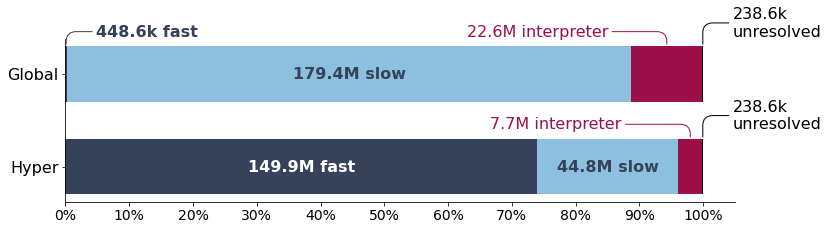

In [195]:
rel = 0
h = 0.6
plt.figure(figsize=(12, 3))
ax = plt.gca()
# https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html
n_col = np.array([53, 66, 89]) / 255.0#sns.color_palette()[0]
g_col = np.array([140, 192, 222]) / 255.0 #sns.color_palette()[1]
i_col = np.array([156, 15, 72]) / 255.0 #sns.color_palette()[2]

tg_col = n_col
yq = np.arange(len(df_rows))[::-1]
plt.barh(yq, df_rows['normal'] / total, h, left=rel, color=n_col)

m = rel + df_rows['normal'] / total * .5
ax.text(m[1], 0, '{:.1f}M fast'.format(df_rows['normal'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color='w', fontweight='bold',)

rel += df_rows['normal'] / total
plt.barh(yq, df_rows['general'] / total, h, left=rel, color=g_col)

m = rel + df_rows['general'] / total * .5
ax.text(m[0], 1, '{:.1f}M slow'.format(df_rows['general'].iloc[0] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)
ax.text(m[1], 0, '{:.1f}M slow'.format(df_rows['general'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)


rel += df_rows['general'] / total
plt.barh(yq, df_rows['interpreter'] / total, h, left=rel, color=i_col)
rel += df_rows['interpreter'] / total
plt.barh(yq, df_rows['unresolved'] / total, h, left=rel, color='k')
xq = np.arange(0, 1.1, 0.1)


ax.annotate(
    '{:.1f}k fast'.format(df_rows['normal'].iloc[0] / 1000.0),
    xy=(df_rows['normal'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points', color=n_col, fontweight='bold',
    arrowprops=dict(arrowstyle="-", color=n_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[0] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[0] / total * 0.5, 1 + h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col, 
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[1] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[1] / total * 0.5, h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.xticks(xq, ['{}%'.format(int(x * 100)) for x in xq], fontsize=14)
plt.yticks([0, 1], ['Hyper', 'Global'], fontsize=16)
sns.despine()

plt.savefig('workshop_path_breakdown.pdf', transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)

In [140]:
print(m)

0    0.444679
1    0.850303
dtype: float64


In [37]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    y : float or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : float or array-like
        The width(s) of the bars.
    
    height : float or array-like, default: 0.8
        The heights of the bars.
    
    left : float or array-like, default: 0
        The x coordinates of the left sides of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the base to the *y* coordinates*:
 

In [196]:
df_rows

,normal,general,interpreter,unresolved,mode
0,448620,179364496,22635949,238590,nohyper
1,149930703,44830574,7687788,238590,hyper


In [197]:
179364496 / total

0.8849305400469506

In [198]:
448620 / total

0.0022133563092434022